# Introduction and proposed solution 
In the application of deep learning to visual recognition, there is an inherent assumption that the source and target domain data are identical and independently distributed. This assumption does not always hold in the real world. The Domain Shift has been addressed by multiple techniques such as hand-crafted features [1,2] and deep models [3,4,5]. Recently, the use of deep domain adaptation using Adaptive Batch Normalization (AdaBN) [6] has been shown to be promising. Inspired by [7], in this work, we use specific Domain Alignment Layers, designed to match the source and target feature distributions to a reference one.  

We consider a source dataset $S =\{{X^S_i,y^S_i}\}$ of images and associated labels, and an unlabelled dataset $T = \{{X^S_i}\}_{i=1}^{N_s}$, where $X_i \in 𝒳$ and $y\in 𝒴$, $𝒴 =\{1,2,...,K \}$ ($K$ denotes the number of object categories).   
Given the violation of the i.i.d assumption, and the resulting domain shift, it is expected that the source and target domains each have a specific different predictor. We can, however say that both predictors share a common parameter $θ$ belonging to a set 𝚯. The domain-invariance properties of these predictors are controlled through the Domain-Alignment (DA) layers introduced to the architecture.
The source and target predictors are implemented as neural networks containing the DA layers. The DA layers do the domain alignment to the reference distribution. This alignment uses the first and second order moments, the mean and standard deviation. The predictors thus share the same network and differ only in the Batch Normalization statistics.  

The DA-layer not only calculates the statistics using the input source data but also the target training data.This introduces cross-domain bias and the distributions are mixed by a factor $\alpha \in [0.5,1]$. This parameter controls the extent of domain alignment and is learned during training. 
In a separate experiment, we also explore the use of a pretrained AlexNet Backbone model [8] and a ResNet Backbone.

## Importing the necessary libraries

In [1]:
import os
import torch
import torch.nn as nn
from os import makedirs
from tqdm import tqdm 
import shutil 
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F


In [2]:
# !nvidia-smi

In [3]:
# GPU launch blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# free cache
torch.cuda.empty_cache()
# PYTORCH_CUDA_ALLOC_CONF = max_split_size_mb:2000

## Mounting the google drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Create the online dataset folder 
!mkdir dataset
!cp "gdrive/MyDrive/datasets/Adaptiope.zip" dataset/
!ls dataset

Adaptiope.zip


In [7]:
# Unzip dataset files into the created folder
!unzip dataset/Adaptiope.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: dataset/Adaptiope/synthetic/purse/purse_

In [8]:
# !rm -rf dataset/Adaptiope
!rm -rf dataset/Adaptiope_small

## Dataset
We examined our proposed network on a publicly available dataset Adaptiope which has three domain such as (Synthetic, Product and Real World). Every domain comprises with 123 objects. We extracted 20 objects randomly from the Product and Real World domain and imported it into a folder named with *Adaptiope_small* subsetting with the several domains. The dataset maintained the file system structure expected from the torchvision.datasets.ImageFolder utility.

In [9]:
!mkdir dataset/Adaptiope_small
# classes = os.listdir("Adaptiope/product_images")
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]
           
for d, td in zip(["dataset/Adaptiope/product_images", "dataset/Adaptiope/real_life"], ["dataset/Adaptiope_small/product_images", "dataset/Adaptiope_small/real_life"]):
  
  try:
    makedirs(td)    # Create the directory for the given domain in adaptiope_small 
  except:
    pass 

  for c in tqdm(classes):  # For each class 
    #print(c)
    c_path = os.path.join(d, c)
    c_target = os.path.join(td, c)
    shutil.copytree(c_path, c_target)

100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


In [10]:

def get_data(batch_size, img_root_source, img_root_target):
  '''
  Function to load the dataset, transform it and create data loaders.
  Input arguments:
    batch_size: mini batch size used during training
    img_root: path to the dataset parent folder. 
              The folder just above the sub-folders or class folders 
  Output: data loaders
  '''
  # prepare data transformations for the train loader Source
  transform = list()
  transform.append(T.Resize((108,108)))                      # resize each PIL image to 108x108. These parameters were empirically estimated depending on GPU load and resulting accuracy 
  transform.append(T.RandomCrop((96,96)))                  # randomly crop a 96x96 patch. These parameters were empirically estimated depending on GPU load and resulting accuracy
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))    # normalizes the Tensors between [-1, 1]

  transform = T.Compose(transform)                     # compose the above transformations into one

    
  # load data source
  adaptiope_small_dataset_source = torchvision.datasets.ImageFolder(root=img_root_source, transform=transform)

  # load data target
  adaptiope_small_dataset_target = torchvision.datasets.ImageFolder(root=img_root_target, transform=transform)
  
  # create train and test splits (80/20) for Source
  num_samples_source = len(adaptiope_small_dataset_source)              # total sample 2000
  training_samples_source = int(num_samples_source * 0.8 + 1)           # training sample 1601
  test_samples_source = num_samples_source - training_samples_source    # test sample 399

  # create train and test splits (80/20) for Target
  num_samples_target = len(adaptiope_small_dataset_target)              # total sample 2000
  training_samples_target = int(num_samples_target * 0.8 + 1)           # training sample 1601
  test_samples_target = num_samples_target - training_samples_target    # test sample 399

  # source
  training_data_source, test_data_source = torch.utils.data.random_split(adaptiope_small_dataset_source, [training_samples_source, test_samples_source])

  # target
  training_data_target, test_data_target = torch.utils.data.random_split(adaptiope_small_dataset_target, [training_samples_target, test_samples_target])

  # initialize dataloaders

  train_loader = torch.utils.data.DataLoader(training_data_source, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(training_data_target, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data_target, batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## Define Networks 
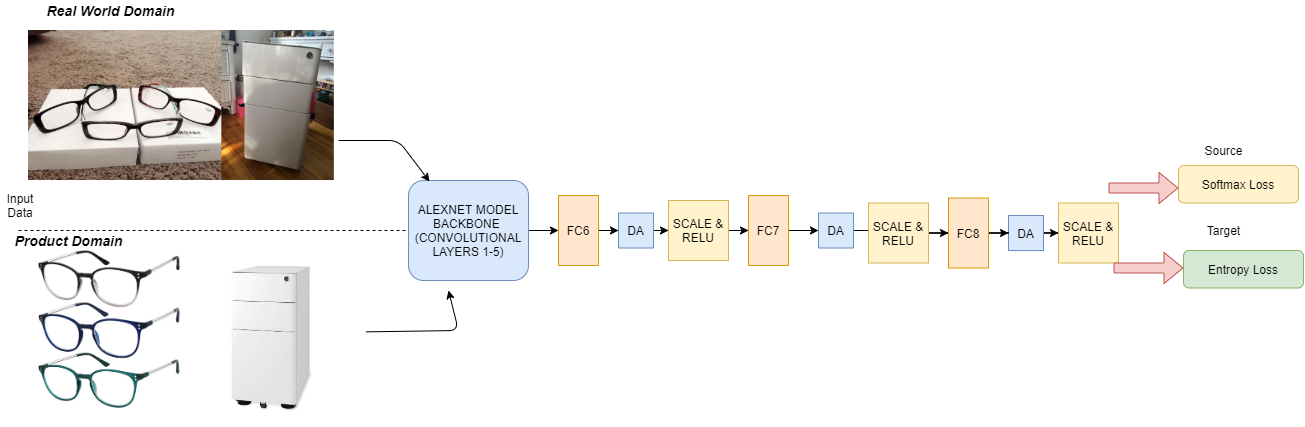

The network receives both source and target images. They enter the DA-layer, where the source and target distributions are aligned, after passing through the initial levels. The DA-layer gains knowledge of the statistics of freshly specified source and target cross-domain distributions and normalizes the source and target mini-batches in accordance with the computed mean and variance, which are distinct for the two domains. Two deep neural network which are almost identical used to implement the source and target domain. Two network share the same structure as well as the same weights represented by θ. However, a couple of special layer consisting of two networks. Such layer is to use a data transformation to match a reference distributions with the observed input distribution. the two domains undergo different transformations in the corresponding DA-layers.

The actual implementation of DA Layer is inspired by the Batch Normalization which layers separately match the first and second order moments of the source and target distributions to a normal distribution. 

DA Layer: The DA layer is derived from the Bath Normalization. Using the input direction derived from the mini-batch. It computes first and second order moments. As the both source and target domain share the same network each DA layer in one domain has a matching DA layer in other domain. Let $x_s$ and $x_t$
to stand for the inputs to the corresponding matching DA-layers in the source and target domain, respectively. Allow $q^s$, $q^t$ is to be the distribution of $x_s$ and $x_t$ respectively and let ${q_α^{st}}$ = ${αq^s + (1 − α)q^t}$ and, symmetrically, ${q_α^{ts} = αq^t + (1−α)q^s}$ be cross-domain distributions mixed by a factor $α \in [0:5; 1]$. The output of the DA Layers in source and target domain is given below respectively.

$DA(x_s;α)$ = $\frac{x_s - µ_{st,α}}{\sqrt{\in + σ^2_{st,σ}}}$    
$DA(x_t;α)$ = $\frac{x_t - µ_{ts,α}}{\sqrt{\in + σ^2_{ts,σ}}}$

${\in}$ should be greater than 0 and a small number to avoid numerical issues in case of zero variance. We derive similarity the gradients through the statistics that based on mini-batch. When mixing factor $α = 1$ we can have an independent alignment. When $α = 0.5$ we have a coupled normalization. In the earlier case the DA layer computes two several functions in the source and target domain. The later case transform two domains equally with the same function with $q^{st}_{0.5} = q^{ts}_{0.5}$. As the mixing parameter $α$ is not fixed it was learned in training phase.

In [11]:
# DIALNet implementation with an AlexNet Backbone 
class DIALNet(nn.Module):
  def __init__(self):
    super(DIALNet, self).__init__() 
    # Initialize AlexNet Model Backbone
    self.alexnet = torchvision.models.alexnet(pretrained=True) 
    in_features = self.alexnet.classifier[6].in_features      # We take all layers except the output to get maximum information from AlexNet
    self.alexnet.classifier = self.alexnet.classifier[:6]  # Select all layers but the output layer
    self.fc4 = nn.Linear(in_features, 256)   # fully connected layer 256 is a good compromise between too low and too high
    self.bns4 = nn.BatchNorm1d(256, affine=False)
    self.bnt4 = nn.BatchNorm1d(256, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 256))
    self.beta4 = nn.Parameter(torch.zeros(1, 256))

    self.fc5 = nn.Linear(256, 224)							# in feature [size of each input sample], out feature [size of each output sample]
    self.bns5 = nn.BatchNorm1d(224, affine=False) # 224 arbitrary, same order as 256
    self.bnt5 = nn.BatchNorm1d(224, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 224))
    self.beta5 = nn.Parameter(torch.zeros(1, 224))

    self.fc6 = nn.Linear(224, 20)  # There are 20 categories, so the output layer should have 20 nodes
    self.bns6 = nn.BatchNorm1d(20, affine=False)
    self.bnt6 = nn.BatchNorm1d(20, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 20))
    self.beta6 = nn.Parameter(torch.zeros(1, 20))


  def forward(self, x):

    if self.training:
      x = self.alexnet(x) 
      x = self.fc4(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = F.dropout(F.relu(torch.cat((self.bns4(x_source), self.bnt4(x_target)), dim=0)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = F.dropout(F.relu(torch.cat((self.bns5(x_source), self.bnt5(x_target)), dim=0)*self.gamma5 + self.beta5), training=self.training)
      x = self.fc6(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns6(x_source), self.bnt6(x_target)), dim=0)*self.gamma6 + self.beta6 
        

    else:
      # for target domain it's not required splitting
      x = self.alexnet(x)
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6 
      
    return x

In [12]:
# DIALNet without a Backbone module for the Source-only scenario 
class srcDIALNet(nn.Module):

	def __init__(self):
   
		super(srcDIALNet, self).__init__()
	

		self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)											# BN layers has 3, 16 features, since this the number of outputs of the convolution
		self.bns1 = nn.BatchNorm2d(16, affine=False) 																# batch normalization for source, we disabled affine transformation because we want to apply the same one to the output of the both BN
		self.bnt1 = nn.BatchNorm2d(16, affine=False)																# batch normalization for target
		self.gamma1 = nn.Parameter(torch.ones(16, 1, 1))
		self.beta1 = nn.Parameter(torch.zeros(16, 1, 1))


		self.conv2 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
		self.bns2 = nn.BatchNorm2d(16, affine=False)
		self.bnt2 = nn.BatchNorm2d(16, affine=False)
		self.gamma2 = nn.Parameter(torch.ones(16, 1, 1))
		self.beta2 = nn.Parameter(torch.zeros(16, 1, 1))

		self.conv3 = nn.Conv2d(16, 128, kernel_size=5, padding=2)                   # Increment output channels ->128 to get more features 
		self.bns3 = nn.BatchNorm2d(128, affine=False)
		self.bnt3 = nn.BatchNorm2d(128, affine=False)
		self.gamma3 = nn.Parameter(torch.ones(128, 1, 1))
		self.beta3 = nn.Parameter(torch.zeros(128, 1, 1))

		self.fc4 = nn.Linear(67712, 256)                     												# fully connected layer 67712 size of the input from conv layers 
		self.bns4 = nn.BatchNorm1d(256, affine=False)
		self.bnt4 = nn.BatchNorm1d(256, affine=False)
		self.gamma4 = nn.Parameter(torch.ones(1, 256))
		self.beta4 = nn.Parameter(torch.zeros(1, 256))

		self.fc5 = nn.Linear(256, 224)																						# in feature [size of each input sample], out feature [size of each output sample]
		self.bns5 = nn.BatchNorm1d(224, affine=False)
		self.bnt5 = nn.BatchNorm1d(224, affine=False)
		self.gamma5 = nn.Parameter(torch.ones(1, 224))
		self.beta5 = nn.Parameter(torch.zeros(1, 224))

		self.fc6 = nn.Linear(224, 20)
		self.bns6 = nn.BatchNorm1d(20, affine=False)
		self.bnt6 = nn.BatchNorm1d(20, affine=False)
		self.gamma6 = nn.Parameter(torch.ones(1, 20))
		self.beta6 = nn.Parameter(torch.zeros(1, 20))

	def forward(self, x):

		if self.training:
			x = self.conv1(x)
			x = F.max_pool2d(F.relu(self.bnt1(x)*self.gamma1 + self.beta1), kernel_size=3, stride=2)

			x = self.conv2(x)
			x = F.max_pool2d(F.relu(self.bnt2(x)*self.gamma2 + self.beta2), kernel_size=3, stride=2)

			x = self.conv3(x)
			x = F.relu(self.bnt3(x)*self.gamma3 + self.beta3)

			x = x.view(x.shape[0], -1)
			x = self.fc4(x)
			x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

			x = self.fc5(x)
			x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

			x = self.fc6(x)
			x = self.bnt6(x)*self.gamma6 + self.beta6
		else:
			# for target domain it's not required splitting
			x = self.conv1(x)
			x = F.max_pool2d(F.relu(self.bnt1(x)*self.gamma1 + self.beta1), kernel_size=3, stride=2)

			x = self.conv2(x)
			x = F.max_pool2d(F.relu(self.bnt2(x)*self.gamma2 + self.beta2), kernel_size=3, stride=2)

			x = self.conv3(x)
			x = F.relu(self.bnt3(x)*self.gamma3 + self.beta3)

			x = x.view(x.shape[0], -1)
			x = self.fc4(x)
			x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

			x = self.fc5(x)
			x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

			x = self.fc6(x)
			x = self.bnt6(x)*self.gamma6 + self.beta6
      
		return x

In [13]:
# DIALNet with AlexNet Backbone for the source only scenario 
class srcDIALexNet(nn.Module):
  def __init__(self):
    super(srcDIALexNet, self).__init__() 
    # Initialize an AlexNet Model Backbone 
    self.alexnet = torchvision.models.alexnet(pretrained=True) 
    in_features = self.alexnet.classifier[6].in_features 
    self.alexnet.classifier = self.alexnet.classifier[:6]  
    self.fc4 = nn.Linear(in_features, 256)      														# fully connected layer
    self.bns4 = nn.BatchNorm1d(256, affine=False)
    self.bnt4 = nn.BatchNorm1d(256, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 256))
    self.beta4 = nn.Parameter(torch.zeros(1, 256))

    self.fc5 = nn.Linear(256, 224)																						# in feature [size of each input sample], out feature [size of each output sample]
    self.bns5 = nn.BatchNorm1d(224, affine=False)
    self.bnt5 = nn.BatchNorm1d(224, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 224))
    self.beta5 = nn.Parameter(torch.zeros(1, 224))

    self.fc6 = nn.Linear(224, 20)
    self.bns6 = nn.BatchNorm1d(20, affine=False)
    self.bnt6 = nn.BatchNorm1d(20, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 20))
    self.beta6 = nn.Parameter(torch.zeros(1, 20))


  def forward(self, x):

    if self.training:
      x = self.alexnet(x) 
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)
      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6
    else:
      # for target domain it's not required splitting
      x = self.alexnet(x)
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6 
      
    return x

# Cost Functions

In [14]:
# cross entropy function for the source domain where we have the labels
def get_ce_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

# Entropy loss for the target domain where we have no labels available 
def get_entropy_loss(x):
  p = F.softmax(x, dim=1)
  q = F.log_softmax(x, dim=1)
  b = p * q
  b = -1.0 * b.sum(-1).mean()
  return b

## Optimizers

In [15]:

def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

In [16]:
# Optimizer with 2 different learning rates 
def get_optimizer2(model, lr, wd, momentum):
  
  # we will create two groups of weights, one for the newly initialized layer
  # and the other for rest of the layers of the network
  
  final_layer_weights = []
  rest_of_the_net_weights = []
  
  # iterate through the layers of the network
  for name, param in model.named_parameters():
    if not 'alexnet' in name:
      final_layer_weights.append(param)
    else:
      rest_of_the_net_weights.append(param)
  
  # assign the distinct learning rates to each group of parameters
  optimizer = torch.optim.SGD([
      {'params': rest_of_the_net_weights},
      {'params': final_layer_weights, 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)
  
  return optimizer

## Training and Test steps

# Training description 
In the training phase, we estimate the parameter $θ$ which holds the weights of the neural network that are shared between the source and target predictors using the provided observations. We use the target samples to estimate a data distribution of the target domain. This will be converted to a posterior distribution given observations of $S$ and $T$. The posterior is maximized over $𝜣$ to obtain the maximum a posteriori estimate of $\theta$. After computing this estimate, we can compute and store the required statistics. The DA-layer is implemented  by modifying the Standard Batch Normalization. The DA-layer simultaneously computes normalization functions and learns the $α$ parameter. During training, we alternate between fixed source and training samples, concatenating the result into a long tensor. The parameter $α$  is clipped in the forward pass of the network during training in $\alpha \in [0.5,1]$. The cross entropy is applied to the source samples and the entropy loss is applied to the target samples. The cumulative loss is a sum of the two loss terms.

In [17]:
def training_step(net, source_data_loader, target_data_loader, optimizer, 
          get_ce_cost_function, entropy_loss_weight, device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_en_loss = 0.
  cumulative_accuracy = 0.
  
  target_iter = iter(target_data_loader)

  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    
    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # forward pass
    outputs = net(inputs)
    
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    
    # apply the losses
    ce_loss = get_ce_cost_function(source_output,targets)
    en_loss = get_entropy_loss(target_output)
    
    loss = ce_loss + entropy_loss_weight * en_loss
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # reset the optimizer
    optimizer.zero_grad()

    # Get statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    
    cumulative_ce_loss += ce_loss.item()
    cumulative_en_loss += en_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_en_loss/target_samples, cumulative_accuracy/source_samples*100


def test_step(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # strictly needed if network contains layers which has different behaviours between train and test
  net.eval()
  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      outputs = net(inputs)

      # apply the loss
      loss = cost_function(outputs, targets)

      # print statistics
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [18]:
# Define a different protocol for training in the source only scenario 
def source_training_step(net, source_data_loader,  optimizer, 
          get_ce_cost_function,  device='cuda:0'):
  source_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_accuracy = 0.
  
  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    
    inputs = inputs_source
    
    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # forward pass
    outputs = net(inputs)
    

    # apply the losses
    ce_loss = get_ce_cost_function(outputs,targets)
    
    loss = ce_loss 
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # reset the optimizer
    optimizer.zero_grad()

    # print statistics
    source_samples+=inputs_source.shape[0]
    
    cumulative_ce_loss += ce_loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_ce_loss, cumulative_accuracy/source_samples*100


def test_step(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # strictly needed if network contains layers which has different behaviours between train and test
  net.eval()
  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      outputs = net(inputs)

      # apply the loss
      loss = cost_function(outputs, targets)

      # Get statistics
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

Main Function

In [19]:

# Main program for the Domain Adaptation
def main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=60,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  '''
  Input arguments
    batch_size: Size of a mini-batch
    device: GPU where you want to train your network
    weight_decay: Weight decay co-efficient for regularization of weights
    momentum: Momentum for SGD optimizer
    epochs: Number of epochs for training the network
  '''
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = DIALNet().to(device)

  optimizer = get_optimizer2(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = training_step(net=net, source_data_loader=train_loader_source, 
                                                         target_data_loader=train_loader_target, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function,
                                                         entropy_loss_weight=entropy_loss_weight)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  

# Main program for the source only 
def source_main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=60,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = srcDIALexNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = source_training_step(net=net, source_data_loader=train_loader_source, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  
# Main program for the source only with AlexNet 
def source_alex_main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=60,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = srcDIALexNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = source_training_step(net=net, source_data_loader=train_loader_source, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  

# Experiments 
Our networks were trained using the stochastic gradient descent with momentum using the following parameters: weight decay=0.000001 for slow decay, batch size=128, the small batches are for computational load restrictions,          learning rate=0.01 for slow learning,  momentum=0.9 for faster convergence, epochs=60 to ensure complete convergence, entropy_loss_weight=0.1 to give a smaller imprtance to the entropy loss. We augment the input data by scaling all images to 108x108 pixels, randomly cropping images to 96x96. We use a pretrained AlexNet backbone (excepting the output layer with a learning rate reduced by 10 to ensure learning on the backbone is less important than on the DA layers). The Domain Alignment layers are upstream of the AlexNet layers. 

##  Real World to Product

In [ ]:
main(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Before training:
	 Test: CE loss 0.03032, Accuracy 3.26
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02358, Entropy loss 0.02087, Accuracy 15.49
	 Test: CE loss 0.01998, Accuracy 49.12
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01697, Entropy loss 0.02019, Accuracy 39.41
	 Test: CE loss 0.01618, Accuracy 57.39
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01474, Entropy loss 0.01920, Accuracy 50.84
	 Test: CE loss 0.01483, Accuracy 61.65
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.01334, Entropy loss 0.01822, Accuracy 56.84
	 Test: CE loss 0.01434, Accuracy 63.66
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.01226, Entropy loss 0.01743, Accuracy 61.15
	 Test: CE loss 0.01369, Accuracy 65.41
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.01124, Entropy loss 0.01646, Acc

In [ ]:
# Source only
source_main(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Before training:
	 Test: CE loss 0.03005, Accuracy 6.27
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02619, Entropy loss 41.93543, Accuracy 7.18
	 Test: CE loss 0.02891, Accuracy 8.52
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.02362, Entropy loss 37.80951, Accuracy 12.62
	 Test: CE loss 0.02911, Accuracy 9.77
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.02217, Entropy loss 35.48964, Accuracy 17.24
	 Test: CE loss 0.02860, Accuracy 14.04
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.02105, Entropy loss 33.70770, Accuracy 21.05
	 Test: CE loss 0.02665, Accuracy 19.55
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.02021, Entropy loss 32.35996, Accuracy 24.23
	 Test: CE loss 0.02571, Accuracy 24.06
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.01938, Entropy loss 31.03515, 

In [ ]:
# Source only alexnet
source_alex_main(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Before training:
	 Test: CE loss 0.03013, Accuracy 7.02
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02319, Entropy loss 37.12959, Accuracy 16.24
	 Test: CE loss 0.01929, Accuracy 48.62
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01691, Entropy loss 27.08051, Accuracy 39.85
	 Test: CE loss 0.01573, Accuracy 54.14
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01480, Entropy loss 23.69555, Accuracy 50.84
	 Test: CE loss 0.01528, Accuracy 59.40
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.01297, Entropy loss 20.76041, Accuracy 58.53
	 Test: CE loss 0.01459, Accuracy 61.40
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.01146, Entropy loss 18.35213, Accuracy 65.96
	 Test: CE loss 0.01442, Accuracy 63.91
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.01015, Entropy loss 16.2534

## Product to real-world

In [ ]:
main(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Before training:
	 Test: CE loss 0.03034, Accuracy 3.01
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.01966, Entropy loss 0.02073, Accuracy 29.92
	 Test: CE loss 0.02185, Accuracy 42.11
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01270, Entropy loss 0.01976, Accuracy 62.65
	 Test: CE loss 0.01919, Accuracy 46.62
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01048, Entropy loss 0.01870, Accuracy 71.71
	 Test: CE loss 0.01816, Accuracy 47.87
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00914, Entropy loss 0.01763, Accuracy 76.76
	 Test: CE loss 0.01820, Accuracy 51.38
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00799, Entropy loss 0.01667, Accuracy 79.01
	 Test: CE loss 0.01752, Accuracy 49.12
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00707, Entropy loss 0.01575, Acc

In [ ]:
# Source only
source_main(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life')


Before training:
	 Test: CE loss 0.03019, Accuracy 5.26
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02031, Entropy loss 32.51430, Accuracy 27.11
	 Test: CE loss 0.02144, Accuracy 39.60
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01279, Entropy loss 20.48091, Accuracy 64.08
	 Test: CE loss 0.02014, Accuracy 42.86
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01019, Entropy loss 16.31741, Accuracy 75.02
	 Test: CE loss 0.01953, Accuracy 47.62
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00840, Entropy loss 13.44824, Accuracy 81.82
	 Test: CE loss 0.01928, Accuracy 45.11
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00715, Entropy loss 11.43972, Accuracy 85.51
	 Test: CE loss 0.01913, Accuracy 48.12
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00611, Entropy loss 9.77552

In [ ]:
# Source only alexnet
source_alex_main(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life')


Before training:
	 Test: CE loss 0.03017, Accuracy 4.01
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02044, Entropy loss 32.72189, Accuracy 28.11
	 Test: CE loss 0.02379, Accuracy 36.09
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01292, Entropy loss 20.68220, Accuracy 63.15
	 Test: CE loss 0.02175, Accuracy 37.34
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01022, Entropy loss 16.35681, Accuracy 74.58
	 Test: CE loss 0.02127, Accuracy 38.10
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00838, Entropy loss 13.41355, Accuracy 82.57
	 Test: CE loss 0.02150, Accuracy 39.35
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00671, Entropy loss 10.73757, Accuracy 86.45
	 Test: CE loss 0.02091, Accuracy 41.35
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00583, Entropy loss 9.33664

# Results and Discussion

Version                                | RW -> P      | P -> RW 
------------------------------         |--------------|------------------
Source Only                            | 38.6         | 49.12 
Source Only - Upper Bound              | 93.32        | 100 
Source Only(AlexNet)                   | 67.42        | 41.1
Source Only(AlexNet) - Upper bound     | 99.69        | 100
DA                                     | 74.69        | 55.39 
DA - Upper Bound                       | 97.81        | 99.25 
Gain - SO                              | 36.09        | 6.27 
Gain(Alexnet) - SO                     | 7.27         | 14.29
Gain(Average)                          | 21.68        | 10.28

> In the direction Real-World->Product, the results seem fairly good. There is a gain of over 36 with respect to the source only accuracy, and over 7 with source only and AlexNet, this indicates that using DIALNet with an AlexNet Backbone offers significant improvement in results. However, this trend is broken in the reverse direction of Product to Real-World. The BN-based Source Only performance is better than the performance of Source only with AlexNet. This does not follow the trend of the direction RW-Prdoduct. Our thesis for this discrepancy is that AlexNet is trained on images in the domain of the real world and thus the distribution and weights of the pretrained model align better with the real world data than the product data. The Product does not thus benefit from the learning carried out by the pretrained model backbone.



# Extension of results 
We hypothesize that a simple increase in the model capacity in terms of depth and width of the fully connected layers can lead to a substantial improvement in performance. We add 2 more fully connected layers of dimensions (1024,2048) and (2048,512) to increase the capacity of the model. We do not apply dropout to these layers as we wish to preserve all connections at this level.

In [20]:
# DIALNet implementation with an AlexNet Backbone 
class extDIALNet(nn.Module):
  def __init__(self):
    super(extDIALNet, self).__init__() 
    # Initialize AlexNet Model Backbone
    self.alexnet = torchvision.models.alexnet(pretrained=True) 
    in_features = self.alexnet.classifier[6].in_features 
    self.alexnet.classifier = self.alexnet.classifier[:6]  # Select all layers but the output layer
    self.fc4 = nn.Linear(in_features, 256)   													# fully connected layer
    self.bns4 = nn.BatchNorm1d(256, affine=False)
    self.bnt4 = nn.BatchNorm1d(256, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 256))
    self.beta4 = nn.Parameter(torch.zeros(1, 256))

    self.fc5 = nn.Linear(256, 1024)							# in feature [size of each input sample], out feature [size of each output sample]
    self.bns5 = nn.BatchNorm1d(1024, affine=False)
    self.bnt5 = nn.BatchNorm1d(1024, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 1024))
    self.beta5 = nn.Parameter(torch.zeros(1, 1024))

    self.fc6 = nn.Linear(1024, 2048)
    self.bns6 = nn.BatchNorm1d(2048, affine=False)
    self.bnt6 = nn.BatchNorm1d(2048, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 2048))
    self.beta6 = nn.Parameter(torch.zeros(1, 2048))

    self.fc7 = nn.Linear(2048, 512)
    self.bns7 = nn.BatchNorm1d(512, affine=False)
    self.bnt7 = nn.BatchNorm1d(512, affine=False)
    self.gamma7 = nn.Parameter(torch.ones(1, 512))
    self.beta7 = nn.Parameter(torch.zeros(1, 512))

    self.fc8 = nn.Linear(512, 20)
    self.bns8 = nn.BatchNorm1d(20, affine=False)
    self.bnt8 = nn.BatchNorm1d(20, affine=False)
    self.gamma8 = nn.Parameter(torch.ones(1, 20))
    self.beta8 = nn.Parameter(torch.zeros(1, 20))


  def forward(self, x):

    if self.training:
      x = self.alexnet(x) 
      x = self.fc4(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = F.dropout(F.relu(torch.cat((self.bns4(x_source), self.bnt4(x_target)), dim=0)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = F.dropout(F.relu(torch.cat((self.bns5(x_source), self.bnt5(x_target)), dim=0)*self.gamma5 + self.beta5), training=self.training)


      x = self.fc6(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns6(x_source), self.bnt6(x_target)), dim=0)*self.gamma6 + self.beta6 
        
      x = self.fc7(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns7(x_source), self.bnt7(x_target)), dim=0)*self.gamma7 + self.beta7

      x = self.fc8(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns8(x_source), self.bnt8(x_target)), dim=0)*self.gamma8 + self.beta8

    else:
      # for target domain it's not required splitting
      x = self.alexnet(x)
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6

      x = self.fc7(x)
      x = self.bnt7(x)*self.gamma7 + self.beta7

      x = self.fc8(x)
      x = self.bnt8(x)*self.gamma8 + self.beta8 
    return x

In [21]:
# DIALNet without a Backbone module for the Source-only scenario 
class extsrcDIALNet(nn.Module):

	def __init__(self):
		super(extsrcDIALNet, self).__init__()

		self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)											# BN layers has 3, 64 features, since this the number of outputs of the convolution
		self.bns1 = nn.BatchNorm2d(16, affine=False) 																# batch normalization for source, we disabled affine transformation because we want to apply the same one to the output of the both BN
		self.bnt1 = nn.BatchNorm2d(16, affine=False)																# batch normalization for target
		self.gamma1 = nn.Parameter(torch.ones(16, 1, 1))
		self.beta1 = nn.Parameter(torch.zeros(16, 1, 1))


		self.conv2 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
		self.bns2 = nn.BatchNorm2d(16, affine=False)
		self.bnt2 = nn.BatchNorm2d(16, affine=False)
		self.gamma2 = nn.Parameter(torch.ones(16, 1, 1))
		self.beta2 = nn.Parameter(torch.zeros(16, 1, 1))

		self.conv3 = nn.Conv2d(16, 128, kernel_size=5, padding=2)
		self.bns3 = nn.BatchNorm2d(128, affine=False)
		self.bnt3 = nn.BatchNorm2d(128, affine=False)
		self.gamma3 = nn.Parameter(torch.ones(128, 1, 1))
		self.beta3 = nn.Parameter(torch.zeros(128, 1, 1))

		self.fc4 = nn.Linear(67712, 256)           															# fully connected layer
		self.bns4 = nn.BatchNorm1d(256, affine=False)
		self.bnt4 = nn.BatchNorm1d(256, affine=False)
		self.gamma4 = nn.Parameter(torch.ones(1, 256))
		self.beta4 = nn.Parameter(torch.zeros(1, 256))

		self.fc5 = nn.Linear(256, 1024)																						# in feature [size of each input sample], out feature [size of each output sample]
		self.bns5 = nn.BatchNorm1d(1024, affine=False)
		self.bnt5 = nn.BatchNorm1d(1024, affine=False)
		self.gamma5 = nn.Parameter(torch.ones(1, 1024))
		self.beta5 = nn.Parameter(torch.zeros(1, 1024))

		self.fc6 = nn.Linear(1024, 2048)
		self.bns6 = nn.BatchNorm1d(2048, affine=False)
		self.bnt6 = nn.BatchNorm1d(2048, affine=False)
		self.gamma6 = nn.Parameter(torch.ones(1, 2048))
		self.beta6 = nn.Parameter(torch.zeros(1, 2048))

		self.fc7 = nn.Linear(2048, 512)
		self.bns7 = nn.BatchNorm1d(512, affine=False)
		self.bnt7 = nn.BatchNorm1d(512, affine=False)
		self.gamma7 = nn.Parameter(torch.ones(1, 512))
		self.beta7 = nn.Parameter(torch.zeros(1, 512))

		self.fc8 = nn.Linear(512, 20)
		self.bns8 = nn.BatchNorm1d(20, affine=False)
		self.bnt8 = nn.BatchNorm1d(20, affine=False)
		self.gamma8 = nn.Parameter(torch.ones(1, 20))
		self.beta8 = nn.Parameter(torch.zeros(1, 20))

	def forward(self, x):

		if self.training:
			x = self.conv1(x)
			x = F.max_pool2d(F.relu(self.bnt1(x)*self.gamma1 + self.beta1), kernel_size=3, stride=2)

			x = self.conv2(x)
			x = F.max_pool2d(F.relu(self.bnt2(x)*self.gamma2 + self.beta2), kernel_size=3, stride=2)

			x = self.conv3(x)
			x = F.relu(self.bnt3(x)*self.gamma3 + self.beta3)

			x = x.view(x.shape[0], -1)
			x = self.fc4(x)
			x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

			x = self.fc5(x)
			x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

			x = self.fc6(x)
			x = self.bnt6(x)*self.gamma6 + self.beta6

			x = self.fc7(x)
			x = self.bnt7(x)*self.gamma7 + self.beta7

			x = self.fc8(x)
			x = self.bnt8(x)*self.gamma8 + self.beta8  
		else:
			# for target domain it's not required splitting
			x = self.conv1(x)
			x = F.max_pool2d(F.relu(self.bnt1(x)*self.gamma1 + self.beta1), kernel_size=3, stride=2)

			x = self.conv2(x)
			x = F.max_pool2d(F.relu(self.bnt2(x)*self.gamma2 + self.beta2), kernel_size=3, stride=2)

			x = self.conv3(x)
			x = F.relu(self.bnt3(x)*self.gamma3 + self.beta3)

			x = x.view(x.shape[0], -1)
			x = self.fc4(x)
			x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

			x = self.fc5(x)
			x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

			x = self.fc6(x)
			x = self.bnt6(x)*self.gamma6 + self.beta6

			x = self.fc7(x)
			x = self.bnt7(x)*self.gamma7 + self.beta7

			x = self.fc8(x)
			x = self.bnt8(x)*self.gamma8 + self.beta8 
			
		return x

In [22]:
# DIALNet with AlexNet Backbone for the source only scenario 
class extsrcDIALexNet(nn.Module):
  def __init__(self):
    super(extsrcDIALexNet, self).__init__() 
    # Initialize an AlexNet Model Backbone 
    self.alexnet = torchvision.models.alexnet(pretrained=True) 
    in_features = self.alexnet.classifier[6].in_features 
    self.alexnet.classifier = self.alexnet.classifier[:6]  
    self.fc4 = nn.Linear(in_features, 256)   #nn.Linear(6272, 3072)															# fully connected layer
    self.bns4 = nn.BatchNorm1d(256, affine=False)
    self.bnt4 = nn.BatchNorm1d(256, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 256))
    self.beta4 = nn.Parameter(torch.zeros(1, 256))

    self.fc5 = nn.Linear(256, 1024)																						# in feature [size of each input sample], out feature [size of each output sample]
    self.bns5 = nn.BatchNorm1d(1024, affine=False)
    self.bnt5 = nn.BatchNorm1d(1024, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 1024))
    self.beta5 = nn.Parameter(torch.zeros(1, 1024))

    self.fc6 = nn.Linear(1024, 2048)
    self.bns6 = nn.BatchNorm1d(2048, affine=False)
    self.bnt6 = nn.BatchNorm1d(2048, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 2048))
    self.beta6 = nn.Parameter(torch.zeros(1, 2048))

    self.fc7 = nn.Linear(2048, 512)
    self.bns7 = nn.BatchNorm1d(512, affine=False)
    self.bnt7 = nn.BatchNorm1d(512, affine=False)
    self.gamma7 = nn.Parameter(torch.ones(1, 512))
    self.beta7 = nn.Parameter(torch.zeros(1, 512))

    self.fc8 = nn.Linear(512, 20)
    self.bns8 = nn.BatchNorm1d(20, affine=False)
    self.bnt8 = nn.BatchNorm1d(20, affine=False)
    self.gamma8 = nn.Parameter(torch.ones(1, 20))
    self.beta8 = nn.Parameter(torch.zeros(1, 20))


  def forward(self, x):

    if self.training:
      x = self.alexnet(x) 
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6

      x = self.fc7(x)
      x = self.bnt7(x)*self.gamma7 + self.beta7

      x = self.fc8(x)
      x = self.bnt8(x)*self.gamma8 + self.beta8 
    else:
      # for target domain it's not required splitting
      x = self.alexnet(x)
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6

      x = self.fc7(x)
      x = self.bnt7(x)*self.gamma7 + self.beta7

      x = self.fc8(x)
      x = self.bnt8(x)*self.gamma8 + self.beta8 
      
    return x

In [23]:

# Main program for the Domain Adaptation - extension
def extmain(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=60,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  '''
  Input arguments
    batch_size: Size of a mini-batch
    device: GPU where you want to train your network
    weight_decay: Weight decay co-efficient for regularization of weights
    momentum: Momentum for SGD optimizer
    epochs: Number of epochs for training the network
  '''
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = extDIALNet().to(device)

  optimizer = get_optimizer2(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = training_step(net=net, source_data_loader=train_loader_source, 
                                                         target_data_loader=train_loader_target, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function,
                                                         entropy_loss_weight=entropy_loss_weight)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  

# Main program for the source only - extension
def extsource_main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=60,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = extsrcDIALNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = source_training_step(net=net, source_data_loader=train_loader_source, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  
# Main program for the source only with AlexNet - extension
def extsource_alex_main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=60,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = extsrcDIALexNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = source_training_step(net=net, source_data_loader=train_loader_source, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  

##  Real World to Product

In [ ]:
extmain(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Before training:
	 Test: CE loss 0.03008, Accuracy 2.76
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02193, Entropy loss 0.02066, Accuracy 21.61
	 Test: CE loss 0.01822, Accuracy 59.15
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01567, Entropy loss 0.01968, Accuracy 46.60
	 Test: CE loss 0.01376, Accuracy 65.16
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01341, Entropy loss 0.01846, Accuracy 56.34
	 Test: CE loss 0.01308, Accuracy 70.43
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.01218, Entropy loss 0.01745, Accuracy 60.77
	 Test: CE loss 0.01203, Accuracy 71.68
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.01098, Entropy loss 0.01642, Accuracy 64.52
	 Test: CE loss 0.01149, Accuracy 71.93
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00997, Entropy loss 0.01536, Acc

In [ ]:
# Source only
extsource_main(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Before training:
	 Test: CE loss 0.03009, Accuracy 4.76
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02196, Entropy loss 35.15655, Accuracy 20.17
	 Test: CE loss 0.01852, Accuracy 44.11
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01608, Entropy loss 25.75010, Accuracy 43.85
	 Test: CE loss 0.01472, Accuracy 58.65
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01350, Entropy loss 21.61568, Accuracy 56.46
	 Test: CE loss 0.01417, Accuracy 62.16
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.01143, Entropy loss 18.30086, Accuracy 65.71
	 Test: CE loss 0.01264, Accuracy 66.67
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.01015, Entropy loss 16.25517, Accuracy 69.64
	 Test: CE loss 0.01297, Accuracy 64.91
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00896, Entropy loss 14.3373

In [ ]:
# Source only alexnet
extsource_alex_main(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Before training:
	 Test: CE loss 0.03006, Accuracy 4.76
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02192, Entropy loss 35.08706, Accuracy 19.74
	 Test: CE loss 0.02071, Accuracy 39.85
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01599, Entropy loss 25.60317, Accuracy 45.16
	 Test: CE loss 0.01443, Accuracy 56.89
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01372, Entropy loss 21.96695, Accuracy 54.47
	 Test: CE loss 0.01422, Accuracy 58.65
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.01167, Entropy loss 18.68230, Accuracy 64.46
	 Test: CE loss 0.01345, Accuracy 63.66
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.01034, Entropy loss 16.54750, Accuracy 69.46
	 Test: CE loss 0.01248, Accuracy 65.91
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00895, Entropy loss 14.3265

## Product to real-world

In [ ]:
extmain(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Before training:
	 Test: CE loss 0.03001, Accuracy 5.76
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.01797, Entropy loss 0.02046, Accuracy 37.79
	 Test: CE loss 0.02727, Accuracy 38.85
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01091, Entropy loss 0.01906, Accuracy 71.58
	 Test: CE loss 0.02576, Accuracy 40.60
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.00877, Entropy loss 0.01767, Accuracy 77.51
	 Test: CE loss 0.02561, Accuracy 44.61
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00739, Entropy loss 0.01660, Accuracy 81.82
	 Test: CE loss 0.02526, Accuracy 47.12
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00655, Entropy loss 0.01562, Accuracy 84.01
	 Test: CE loss 0.02483, Accuracy 47.62
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00596, Entropy loss 0.01478, Acc

In [ ]:
# Source only
extsource_main(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life')


Before training:
	 Test: CE loss 0.03001, Accuracy 5.01
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02278, Entropy loss 36.46894, Accuracy 17.30
	 Test: CE loss 0.03034, Accuracy 6.52
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01784, Entropy loss 28.56664, Accuracy 37.10
	 Test: CE loss 0.03183, Accuracy 7.52
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.01580, Entropy loss 25.29654, Accuracy 43.91
	 Test: CE loss 0.03174, Accuracy 8.77
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.01469, Entropy loss 23.51341, Accuracy 49.84
	 Test: CE loss 0.03118, Accuracy 10.03
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.01300, Entropy loss 20.80937, Accuracy 55.97
	 Test: CE loss 0.03152, Accuracy 11.53
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.01210, Entropy loss 19.37797, 

In [24]:
# Source only alexnet
extsource_alex_main(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life', epochs=50)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Before training:
	 Test: CE loss 0.03010, Accuracy 4.01
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.01781, Entropy loss 28.51447, Accuracy 40.72
	 Test: CE loss 0.02178, Accuracy 42.86
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01074, Entropy loss 17.19850, Accuracy 72.02
	 Test: CE loss 0.02015, Accuracy 40.60
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.00815, Entropy loss 13.04526, Accuracy 80.89
	 Test: CE loss 0.01940, Accuracy 47.87
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00681, Entropy loss 10.90574, Accuracy 85.88
	 Test: CE loss 0.01942, Accuracy 45.61
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00547, Entropy loss 8.75607, Accuracy 89.57
	 Test: CE loss 0.01951, Accuracy 47.62
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00455, Entropy loss 7.27871,

In [43]:
# DIALNet extension to a ResNet Backbone 
class extDIALResNet(nn.Module):
  def __init__(self):
    super(extDIALResNet, self).__init__() 
    # Initialize ResNet Model Backbone
    self.resnet = torchvision.models.resnet101(pretrained=True) 
    self.resnet.fc = nn.Linear(2048,1024) 
    self.fc4 = nn.Linear(1024, 256)   													# fully connected layer
    self.bns4 = nn.BatchNorm1d(256, affine=False)
    self.bnt4 = nn.BatchNorm1d(256, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 256))
    self.beta4 = nn.Parameter(torch.zeros(1, 256))

    self.fc5 = nn.Linear(256, 1024)							# in feature [size of each input sample], out feature [size of each output sample]
    self.bns5 = nn.BatchNorm1d(1024, affine=False)
    self.bnt5 = nn.BatchNorm1d(1024, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 1024))
    self.beta5 = nn.Parameter(torch.zeros(1, 1024))

    self.fc6 = nn.Linear(1024, 2048)
    self.bns6 = nn.BatchNorm1d(2048, affine=False)
    self.bnt6 = nn.BatchNorm1d(2048, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 2048))
    self.beta6 = nn.Parameter(torch.zeros(1, 2048))

    self.fc7 = nn.Linear(2048, 512)
    self.bns7 = nn.BatchNorm1d(512, affine=False)
    self.bnt7 = nn.BatchNorm1d(512, affine=False)
    self.gamma7 = nn.Parameter(torch.ones(1, 512))
    self.beta7 = nn.Parameter(torch.zeros(1, 512))

    self.fc8 = nn.Linear(512, 20)
    self.bns8 = nn.BatchNorm1d(20, affine=False)
    self.bnt8 = nn.BatchNorm1d(20, affine=False)
    self.gamma8 = nn.Parameter(torch.ones(1, 20))
    self.beta8 = nn.Parameter(torch.zeros(1, 20))


  def forward(self, x):

    if self.training:
      x = self.resnet(x) 
      x = self.fc4(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = F.dropout(F.relu(torch.cat((self.bns4(x_source), self.bnt4(x_target)), dim=0)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = F.dropout(F.relu(torch.cat((self.bns5(x_source), self.bnt5(x_target)), dim=0)*self.gamma5 + self.beta5), training=self.training)


      x = self.fc6(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns6(x_source), self.bnt6(x_target)), dim=0)*self.gamma6 + self.beta6 
        
      x = self.fc7(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns7(x_source), self.bnt7(x_target)), dim=0)*self.gamma7 + self.beta7

      x = self.fc8(x) 
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0] // 2, dim=0)
      x = torch.cat((self.bns8(x_source), self.bnt8(x_target)), dim=0)*self.gamma8 + self.beta8

    else:
      # for target domain it's not required splitting
      x = self.resnet(x)
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6

      x = self.fc7(x)
      x = self.bnt7(x)*self.gamma7 + self.beta7

      x = self.fc8(x)
      x = self.bnt8(x)*self.gamma8 + self.beta8 
    return x 

# DIALNet with ResNet Backbone for the source only scenario 
class extsrcDIALResNet(nn.Module):
  def __init__(self):
    super(extsrcDIALResNet, self).__init__() 
    # Initialize an ResNet Model Backbone 
    self.resnet = torchvision.models.resnet101(pretrained=True) 
    self.resnet.fc = nn.Linear(2048,1024) 
    self.fc4 = nn.Linear(1024, 256)   #nn.Linear(6272, 3072)															# fully connected layer
    self.bns4 = nn.BatchNorm1d(256, affine=False)
    self.bnt4 = nn.BatchNorm1d(256, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 256))
    self.beta4 = nn.Parameter(torch.zeros(1, 256))

    self.fc5 = nn.Linear(256, 1024)																						# in feature [size of each input sample], out feature [size of each output sample]
    self.bns5 = nn.BatchNorm1d(1024, affine=False)
    self.bnt5 = nn.BatchNorm1d(1024, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 1024))
    self.beta5 = nn.Parameter(torch.zeros(1, 1024))

    self.fc6 = nn.Linear(1024, 2048)
    self.bns6 = nn.BatchNorm1d(2048, affine=False)
    self.bnt6 = nn.BatchNorm1d(2048, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 2048))
    self.beta6 = nn.Parameter(torch.zeros(1, 2048))

    self.fc7 = nn.Linear(2048, 512)
    self.bns7 = nn.BatchNorm1d(512, affine=False)
    self.bnt7 = nn.BatchNorm1d(512, affine=False)
    self.gamma7 = nn.Parameter(torch.ones(1, 512))
    self.beta7 = nn.Parameter(torch.zeros(1, 512))

    self.fc8 = nn.Linear(512, 20)
    self.bns8 = nn.BatchNorm1d(20, affine=False)
    self.bnt8 = nn.BatchNorm1d(20, affine=False)
    self.gamma8 = nn.Parameter(torch.ones(1, 20))
    self.beta8 = nn.Parameter(torch.zeros(1, 20))


  def forward(self, x):

    if self.training:
      x = self.resnet(x) 
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6

      x = self.fc7(x)
      x = self.bnt7(x)*self.gamma7 + self.beta7

      x = self.fc8(x)
      x = self.bnt8(x)*self.gamma8 + self.beta8 
    else:
      # for target domain it's not required splitting
      x = self.resnet(x)
      x = self.fc4(x)
      x = F.dropout(F.relu(self.bnt4(x)*self.gamma4 + self.beta4), training=self.training)

      x = self.fc5(x)
      x = F.dropout(F.relu(self.bnt5(x)*self.gamma5 + self.beta5), training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x)*self.gamma6 + self.beta6

      x = self.fc7(x)
      x = self.bnt7(x)*self.gamma7 + self.beta7

      x = self.fc8(x)
      x = self.bnt8(x)*self.gamma8 + self.beta8 
      
    return x

In [44]:

# Main program for the Domain Adaptation - extension to ResNet
def extmainres(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  '''
  Input arguments
    batch_size: Size of a mini-batch
    device: GPU where you want to train your network
    weight_decay: Weight decay co-efficient for regularization of weights
    momentum: Momentum for SGD optimizer
    epochs: Number of epochs for training the network
  '''
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = extDIALResNet().to(device)

  optimizer = get_optimizer2(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = training_step(net=net, source_data_loader=train_loader_source, 
                                                         target_data_loader=train_loader_target, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function,
                                                         entropy_loss_weight=entropy_loss_weight)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target
  


# Main program for the source only with ResNet - extension
def extsource_res_main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50,
         entropy_loss_weight=0.1,
         img_root_source=None,
         img_root_target=None):
  
  # instantiate dataloaders
  train_loader_source, train_loader_target, test_loader_target = get_data(batch_size=batch_size, img_root_source=img_root_source, img_root_target=img_root_target)
  
  net = extsrcDIALResNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_ce_cost_function()

  # run a single test step beforehand and print metrics
  print('Before training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_ce_loss, train_en_loss, train_accuracy = source_training_step(net=net, source_data_loader=train_loader_source, 
                                                         optimizer=optimizer, get_ce_cost_function=cost_function)
    test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # Compute Final Matrix
  print('After training:')
  test_loss, test_accuracy = test_step(net, test_loader_target, cost_function)

  print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  #return train_loader_source, train_loader_target, test_loader_target

In [47]:
# ResNet backbone DIALNet RW->P
extmainres(img_root_source = '/content/dataset/Adaptiope_small/real_life', img_root_target = '/content/dataset/Adaptiope_small/product_images')


Before training:
	 Test: CE loss 0.03007, Accuracy 5.26
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.02038, Entropy loss 0.02050, Accuracy 27.92
	 Test: CE loss 0.02126, Accuracy 58.65
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01102, Entropy loss 0.01801, Accuracy 70.83
	 Test: CE loss 0.01224, Accuracy 78.45
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.00690, Entropy loss 0.01518, Accuracy 88.07
	 Test: CE loss 0.00857, Accuracy 84.21
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00451, Entropy loss 0.01259, Accuracy 94.57
	 Test: CE loss 0.00684, Accuracy 87.97
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00330, Entropy loss 0.01072, Accuracy 97.63
	 Test: CE loss 0.00690, Accuracy 87.22
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00248, Entropy loss 0.00941, Acc

In [ ]:
# ResNet P->RW
extmainres(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life', epochs=10)


Before training:
	 Test: CE loss 0.03009, Accuracy 5.51
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.01570, Entropy loss 0.02016, Accuracy 50.53
	 Test: CE loss 0.02178, Accuracy 53.63
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.00689, Entropy loss 0.01741, Accuracy 89.13
	 Test: CE loss 0.01369, Accuracy 63.66
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.00432, Entropy loss 0.01502, Accuracy 95.63
	 Test: CE loss 0.01148, Accuracy 67.67
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00307, Entropy loss 0.01302, Accuracy 98.50
	 Test: CE loss 0.01145, Accuracy 67.17
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00234, Entropy loss 0.01170, Accuracy 99.13
	 Test: CE loss 0.01141, Accuracy 67.92
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00202, Entropy loss 0.01037, Acc

In [45]:
# ResNet source only RW->P
extsource_res_main(img_root_source ='/content/dataset/Adaptiope_small/real_life' , img_root_target =  '/content/dataset/Adaptiope_small/product_images')

Before training:
	 Test: CE loss 0.03001, Accuracy 3.01
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.01999, Entropy loss 32.00393, Accuracy 29.17
	 Test: CE loss 0.02090, Accuracy 62.66
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.01120, Entropy loss 17.92982, Accuracy 72.08
	 Test: CE loss 0.01211, Accuracy 75.19
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.00727, Entropy loss 11.63236, Accuracy 87.07
	 Test: CE loss 0.00958, Accuracy 78.95
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00477, Entropy loss 7.63008, Accuracy 94.32
	 Test: CE loss 0.00832, Accuracy 82.71
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00358, Entropy loss 5.73759, Accuracy 97.13
	 Test: CE loss 0.00747, Accuracy 84.21
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00269, Entropy loss 4.31210, 

In [46]:
# ResNet source only P-> RW
extsource_res_main(img_root_source = '/content/dataset/Adaptiope_small/product_images', img_root_target = '/content/dataset/Adaptiope_small/real_life')


Before training:
	 Test: CE loss 0.03007, Accuracy 3.51
-----------------------------------------------------
Epoch: 1
	 Train: CE loss 0.01711, Entropy loss 27.39689, Accuracy 43.66
	 Test: CE loss 0.02278, Accuracy 44.36
-----------------------------------------------------
Epoch: 2
	 Train: CE loss 0.00784, Entropy loss 12.55872, Accuracy 85.82
	 Test: CE loss 0.01669, Accuracy 57.39
-----------------------------------------------------
Epoch: 3
	 Train: CE loss 0.00502, Entropy loss 8.04281, Accuracy 94.38
	 Test: CE loss 0.01532, Accuracy 60.90
-----------------------------------------------------
Epoch: 4
	 Train: CE loss 0.00352, Entropy loss 5.64105, Accuracy 97.19
	 Test: CE loss 0.01469, Accuracy 59.15
-----------------------------------------------------
Epoch: 5
	 Train: CE loss 0.00268, Entropy loss 4.28637, Accuracy 98.88
	 Test: CE loss 0.01450, Accuracy 62.16
-----------------------------------------------------
Epoch: 6
	 Train: CE loss 0.00232, Entropy loss 3.71454, A

# Extension discussion 
> When we **increase the model capacity**, we get gains in accuracy, howbeit small. 
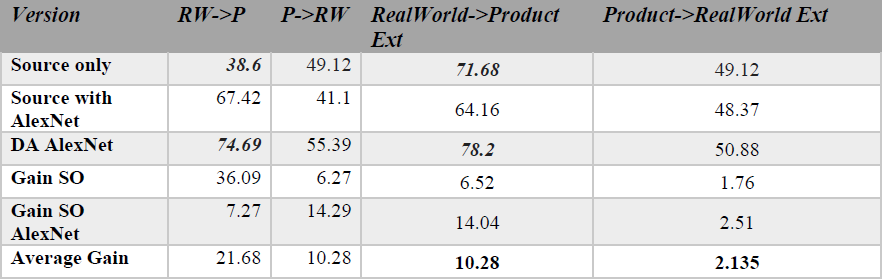

The use of AlexNet Backbone improves performance in RW->P direction and degrades performance in the opposite direction.

In terms of Domain Adaptation, at the preliminary state from Real World to Product and from Product to Real World  the accuracy was 74.69 and 55.39 respectively. But in extension state the accuracy was increased for the training of Real World to Product direction but accuracy was decreased for the training of opposite direction.

In case of Gain, at the first training step we got some projected gain for both direction. From Real world to Product direction the gain was 21.68 which was higher than the opposite direction. On the contrary in the extension stage we lost some gain and it was 10.28 for the direction Real World to Product and for Product to Real World direction the gain was about 2 which is very low.

The graph below visualizes these results better:
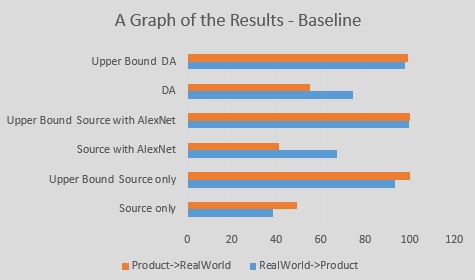

> However, when we **upgrade the backbone to the more complex REsNet101**, we get much higher gains in accuracy in the region of 91% down from 78.2% (14 % points). This implies that much of the accuracy is attributed to use of the correct backbone. The performance of the DIALNet method is comparable to that of other methods in literature in the presence of the various backbone models used as shown below. 


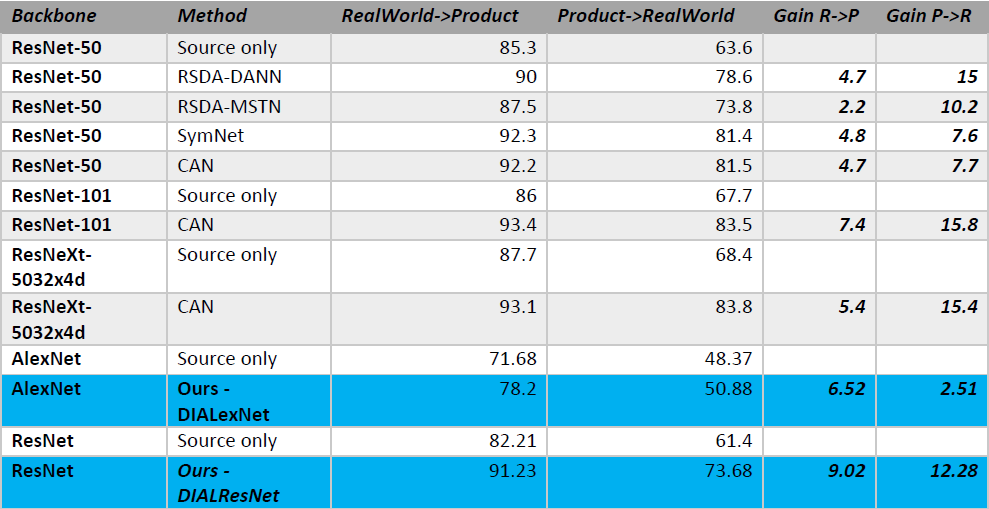

Reference for the results is [7]


# Conclusion 
We carried out experiments on 20 classes of the Adaptiope dataset considering the source only without a backbone, source (labelled) and target (unlabelled) in the Domain Adaptation sense, both scenarios with an AlexNet backbone model and the DIALNet, and both scenarios with a ResNet backbone model and DIALNet. Results show that the backbone models contribute very highly to the achieved accuracy. The gains achieved by our work are better than or at par with other methods in literature. 

# References 
> [1] J. Huang, A. Gretton, K. M. Borgwardt, B. Sch¨olkopf, and
A. J. Smola. Correcting sample selection bias by unlabeled
data. In NIPS, 2006.

> [2] B. Gong, K. Grauman, and F. Sha. Connecting the dots with
landmarks: Discriminatively learning domain-invariant features
for unsupervised domain adaptation. In ICML, 2013.

> [3] M. Long and J. Wang. Learning transferable features with
deep adaptation networks. In ICML, 2015. 

> [4] E. Tzeng, J. Hoffman, T. Darrell, and K. Saenko. Simultaneous
deep transfer across domains and tasks. In ICCV, 2015.

> [5] Y. Ganin and V. Lempitsky. Unsupervised domain adaptation
by backpropagation. ICML, 2015. 


> [6] Y. Li, N. Wang, J. Shi, J. Liu, and X. Hou. Revisiting
batch normalization for practical domain adaptation. arXiv
preprint arXiv:1603.04779, 2016. 


> [7] F.M. Carlucci, L. Porzi, B. Caputo, E.Ricci, S.R. Bulo. AutoDIAL: Automatic DomaIn Alignment Layers. Nov 2017 


> [8] A. Krizhevsky, I. Sutskever, and G. E. Hinton. Imagenet
classification with deep convolutional neural networks. In
NIPS, 2012.

